In [166]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from scipy.optimize import newton
from scipy.stats import norm
import datetime

In [122]:
def calculate_pv(future_value,annual_rate,years,compounding_frequency=1):
    rate_per_period = annual_rate/compounding_frequency
    total_period = years * compounding_frequency
    present_value = future_value/ ((1+ rate_per_period)**total_period)
    return present_value

pv_future_value = 1000 
pv_annual_rate = 0.05
pv_years = 2
pv_compounding_frequency=2

result = calculate_pv(pv_future_value,pv_annual_rate,pv_years,pv_compounding_frequency)
print(f"{result:.2f}")

905.95


Present Value of Bond 1 : 1019.04
Present Value of Bond 2 : 963.27
Visualisation of Bond prices vs YTM


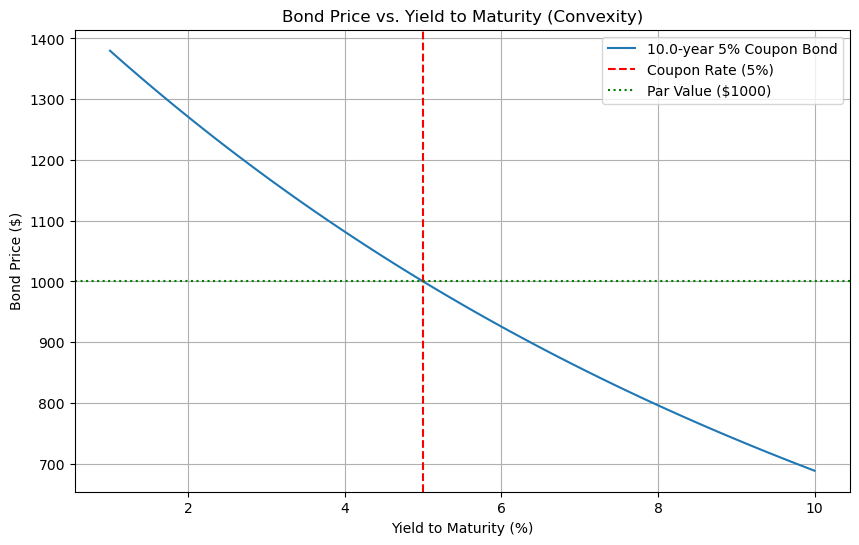

In [124]:
class Bond:
    def __init__(self,face_value,coupon_rate,maturity_years,coupon_frequency):
        self.face_value= float(face_value)
        self.coupon_rate = float(coupon_rate)
        self.maturity_years = float(maturity_years)
        self.coupon_frequency = int(coupon_frequency)
        self.total_period = self.maturity_years * self.coupon_frequency
        self.rate_per_period = self.coupon_rate/self.coupon_frequency
        self.coupon_payments = (self.face_value * self.coupon_rate)/self.coupon_frequency
    
    def generate_cash_flow (self):
        cash_flows = []
        time_interval_per_payment = 1/self.coupon_frequency
        for i in range(1,int(self.total_period)+1):
            current_time_point = i * time_interval_per_payment
            if i == self.total_period:
                cash_flows.append((current_time_point, self.face_value+self.coupon_payments))
            else:
                cash_flows.append((current_time_point, self.coupon_payments))

        return cash_flows

    def __str__(self):
        freq_map = {1:"Annual",2:"Semi Annual",4:"Quarterly",12:"Monthly"}
        freq_str = freq_map.get(self.coupon_frequency,"others")
        return(f"Bond Pricing:\n"
               f"Face Value : {self.face_value:.2f}\n"
               f"Coupon Rate :{self.coupon_rate}%\n"
                f"Maturity Years : {self.maturity_years}\n"
                f"Coupon Frequency : {self.coupon_frequency} times per year, {freq_str}\n"
                f"Coupon Payment : {self.coupon_payments:.2f}")

def calculate_basic_bond_pricing(bond_object,ytm):
    cash_flows = bond_object.generate_cash_flow()
    total_price = 0.0
    for time_point,amount in cash_flows:
        cal_pv = calculate_pv(amount,ytm,time_point,bond_object.coupon_frequency)
        total_price += cal_pv
    return total_price

bond_1 = Bond(face_value = 1000,coupon_rate = 0.05, maturity_years = 2, coupon_frequency= 2)
ytm_1 = 0.04
price_1 = calculate_basic_bond_pricing(bond_1,ytm_1)
print(f"Present Value of Bond 1 : {price_1:.2f}")
        
bond_2 = Bond(face_value = 1000,coupon_rate = 0.05, maturity_years = 2, coupon_frequency= 2)
ytm_2 = 0.07
price_2 = calculate_basic_bond_pricing(bond_2,ytm_2)
print(f"Present Value of Bond 2 : {price_2:.2f}")

print("Visualisation of Bond prices vs YTM")

bond_plot = Bond(face_value = 1000,coupon_rate = 0.05, maturity_years = 10, coupon_frequency = 2)
ytm_range = np.linspace(0.01,0.10,100)

prices = []

for ytm_value in ytm_range:
    price = calculate_basic_bond_pricing(bond_plot,ytm_value)
    prices.append(price)

plt.figure(figsize=(10, 6))
plt.plot(ytm_range * 100, prices, label=f'{bond_plot.maturity_years}-year {bond_plot.coupon_rate*100:.0f}% Coupon Bond')
plt.axvline(bond_plot.coupon_rate * 100, color='r', linestyle='--', label=f'Coupon Rate ({bond_plot.coupon_rate*100:.0f}%)')
plt.axhline(bond_plot.face_value, color='g', linestyle=':', label=f'Par Value (${bond_plot.face_value:.0f})')
plt.title('Bond Price vs. Yield to Maturity (Convexity)')
plt.xlabel('Yield to Maturity (%)')
plt.ylabel('Bond Price ($)')
plt.grid(True)
plt.legend()
plt.show()

In [126]:
sample_maturities = np.array([0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0])
sample_spot_rates_normal = np.array([0.02, 0.022, 0.024, 0.026, 0.030, 0.035, 0.038, 0.040, 0.045, 0.047])
sample_spot_rates_inverted = np.array([0.04, 0.038, 0.036, 0.034, 0.030, 0.028, 0.026, 0.025, 0.024, 0.023])

#interpolate spot rates

def interpolate_spot_rate(target_maturity,curve_maturity,curve_spot_rate):
    if target_maturity > curve_maturity[-1] or target_maturity < curve_maturity[0]:
        raise ValueError(f" Target maturity {target_maturity:.2f} lies out of range")

    idx = np.searchsorted(curve_maturity,target_maturity)

    if target_maturity in curve_maturity:
        return curve_spot_rate[np.where(curve_maturity==target_maturity)[0][0]]
    M1 = curve_maturity[idx-1]
    R1 = curve_spot_rate[idx-1]
    M2 = curve_maturity[idx]
    R2 = curve_spot_rate[idx]

    interpolated_spot_rate = R1 + (R2-R1)*((target_maturity-M1)/(M2-M1))
    return interpolated_spot_rate

def calculate_bond_pricing_spot_curve(bond_object,curve_maturity,curve_spot_rate):
    cash_flow = bond_object.generate_cash_flow()
    total_price = 0.0
    for time_point , amount in cash_flow:
        spot_rate_cfs = interpolate_spot_rate(time_point,curve_maturity,curve_spot_rate)
        pv_of_cfs =calculate_pv(amount,spot_rate_cfs,time_point,bond_object.coupon_frequency)
        total_price += pv_of_cfs
    return total_price

bond_3 = Bond(face_value = 1000,coupon_rate = 0.05, maturity_years = 4, coupon_frequency= 2)
print(f"Bond Stats : {bond_3}")
print(f"Normal Yeild Curve")
price_3 = calculate_bond_pricing_spot_curve(bond_3,sample_maturities,sample_spot_rates_normal)
print(f"Pricing of bond 3(Normal): {price_3:.2f}")

price_3_1 = calculate_bond_pricing_spot_curve(bond_3,sample_maturities,sample_spot_rates_inverted)
print(f"Pricing of bond 3 (Inverted): {price_3_1:.2f}")

Bond Stats : Bond Pricing:
Face Value : 1000.00
Coupon Rate :0.05%
Maturity Years : 4.0
Coupon Frequency : 2 times per year, Semi Annual
Coupon Payment : 25.00
Normal Yeild Curve
Pricing of bond 3(Normal): 1066.68
Pricing of bond 3 (Inverted): 1077.67


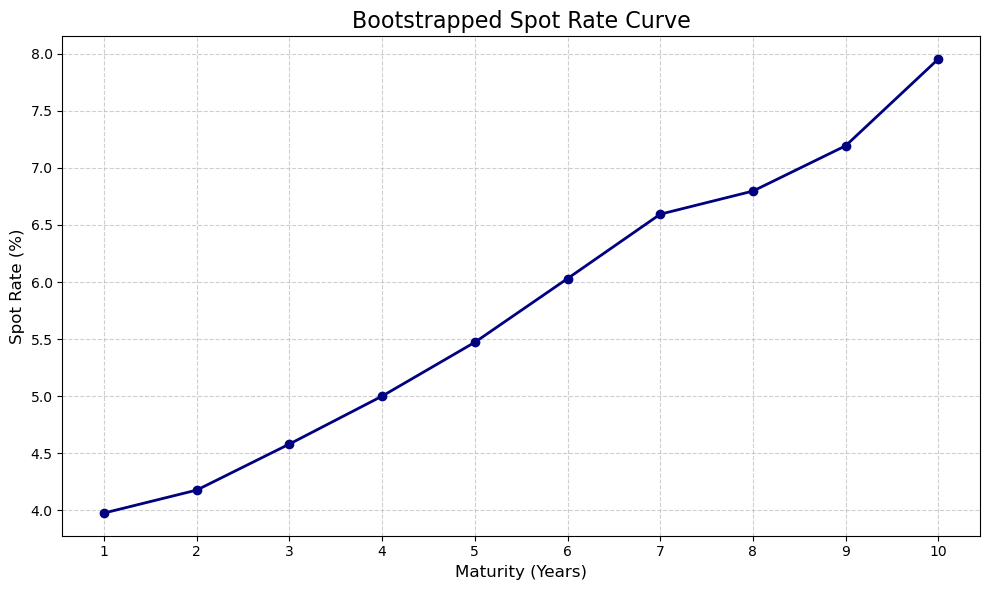

{1.0: 0.0397553516819571, 2.0: 0.04176819595620667, 3.0: 0.04580437467211937, 4.0: 0.0500025294163767, 5.0: 0.05472073035935036, 6.0: 0.06030425185524912, 7.0: 0.06594547842993756, 8.0: 0.06797086419103884, 9.0: 0.07193942688807278, 10.0: 0.07954413953645074}


In [128]:
def bootstrap_spot_curve(bond_list,market_prices):
    spot_curve = {}

    for idx, bond in enumerate(sorted(bond_list, key=lambda b: b.maturity_years)):
        cash_flows = bond.generate_cash_flow()
        market_price = market_prices[idx]  # match by index

        def bond_price_from_spot(r_last):
            total = 0.0
            for t, cf in cash_flows[:-1]:
                if t in spot_curve:
                    total += calculate_pv(cf, spot_curve[t], t, bond.coupon_frequency)
                else:
                    return 1e9  # invalid trial
            # final CF discounted with unknown r
            t_last, cf_last = cash_flows[-1]
            total += calculate_pv(cf_last, r_last, t_last, bond.coupon_frequency)
            return total

        def objective(r):
            return bond_price_from_spot(r) - market_price

        spot_rate = newton(objective, x0=0.05)  # initial guess
        spot_curve[cash_flows[-1][0]] = spot_rate

    return spot_curve

# Simulated bond list and their corresponding market prices

bond_list = [
    Bond(100, 0.02, 1, 1),  # B1
    Bond(100, 0.025, 2, 1), # B2
    Bond(100, 0.03, 3, 1),  # B3
    Bond(100, 0.035, 4, 1), # B4
    Bond(100, 0.04, 5, 1),  # B5
    Bond(100, 0.045, 6, 1), # B6
    Bond(100, 0.05, 7, 1),  # B7
    Bond(100, 0.052, 8, 1), # B8
    Bond(100, 0.055, 9, 1), # B9
    Bond(100, 0.06, 10, 1)  # B10
]

market_prices = [98.10, 96.85, 95.70, 94.80, 94.00, 93.10, 92.40, 91.75, 91.00, 90.20]


def plot_spot_curve(spot_curve):
    years = sorted(spot_curve.keys())
    rates = [spot_curve[yr] * 100 for yr in years]  # Convert to percentages

    plt.figure(figsize=(10, 6))
    plt.plot(years, rates, marker='o', linestyle='-', color='navy', linewidth=2)
    plt.title("Bootstrapped Spot Rate Curve", fontsize=16)
    plt.xlabel("Maturity (Years)", fontsize=12)
    plt.ylabel("Spot Rate (%)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(years)
    plt.tight_layout()
    plt.show()
    
spot_curve = bootstrap_spot_curve(bond_list, market_prices)
spot_curve
plot_spot_curve(spot_curve)
print(f"{spot_curve}")

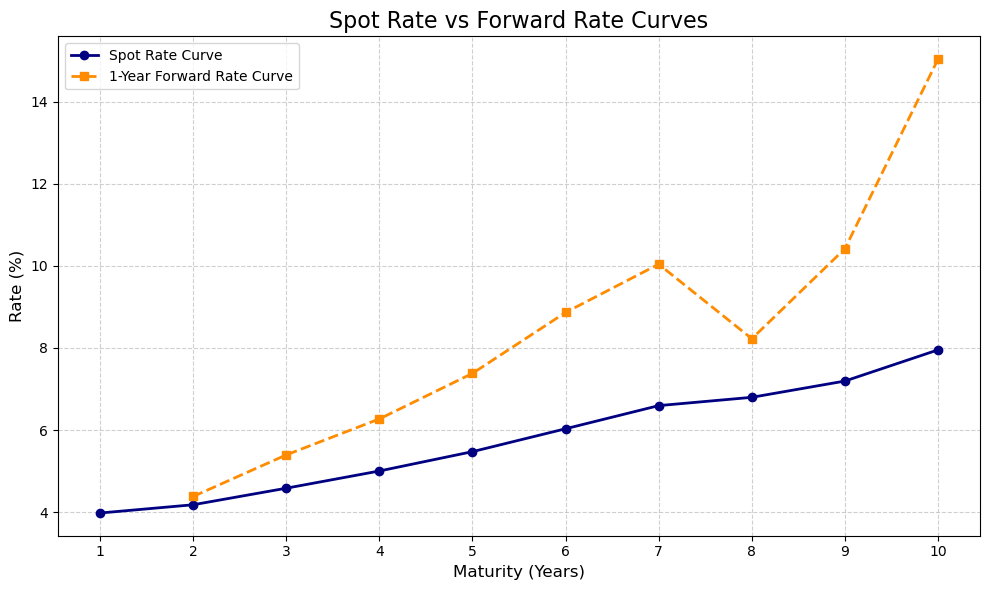

In [130]:
def calculate_forward_rate_from_spot_curve(s1, s2, t1, t2):
   
    forward_rate = ((1 + s2)**t2 / (1 + s1)**t1)**(1 / (t2 - t1)) - 1
    return forward_rate


def generate_forward_rates_from_spot_curve(spot_curve):
    
    maturities = sorted(spot_curve.keys())
    forward_rates = {}

    for i in range(len(maturities) - 1):  # ✅ corrected
        t1 = maturities[i]
        t2 = maturities[i + 1]
        s1 = spot_curve[t1]
        s2 = spot_curve[t2]

        fwd_rate = calculate_forward_rate_from_spot_curve(s1, s2, t1, t2)
        forward_rates[(t1, t2)] = fwd_rate  # tuple key like (1,2)

    return forward_rates


import matplotlib.pyplot as plt

def calculate_forward_rate_from_spot_curve(s1, s2, t1, t2):
    
    forward_rate = ((1 + s2)**t2 / (1 + s1)**t1)**(1 / (t2 - t1)) - 1
    return forward_rate


def generate_forward_rates_from_spot_curve(spot_curve):
    
    maturities = sorted(spot_curve.keys())
    forward_rates = {}

    for i in range(len(maturities) - 1):  # ✅ corrected
        t1 = maturities[i]
        t2 = maturities[i + 1]
        s1 = spot_curve[t1]
        s2 = spot_curve[t2]

        fwd_rate = calculate_forward_rate_from_spot_curve(s1, s2, t1, t2)
        forward_rates[(t1, t2)] = fwd_rate  # tuple key like (1,2)

    return forward_rates


def plot_spot_and_forward_curve(spot_curve, forward_rates):
    
    # Spot Curve Data
    years = sorted(spot_curve.keys())
    spot_rates = [spot_curve[yr] * 100 for yr in years]  # %

    # Forward Curve Data (1-year intervals only)
    fwd_maturities = [end for (start, end) in forward_rates if end - start == 1]
    fwd_rates = [forward_rates[(start, end)] * 100 for (start, end) in forward_rates if end - start == 1]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(years, spot_rates, marker='o', linestyle='-', color='navy', linewidth=2, label='Spot Rate Curve')
    plt.plot(fwd_maturities, fwd_rates, marker='s', linestyle='--', color='darkorange', linewidth=2, label='1-Year Forward Rate Curve')

    plt.title("Spot Rate vs Forward Rate Curves", fontsize=16)
    plt.xlabel("Maturity (Years)", fontsize=12)
    plt.ylabel("Rate (%)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(years)
    plt.legend()
    plt.tight_layout()
    plt.show()

forward_rates = generate_forward_rates_from_spot_curve(spot_curve)
plot_spot_and_forward_curve(spot_curve, forward_rates)

In [158]:
def calculate_bond_pv(bond_object, ytm):
    cash_flows = bond_object.generate_cash_flow()
    pv = 0.0
    for time_point, amount in cash_flows:
        pv += calculate_pv(amount, ytm, time_point, bond_object.coupon_frequency)
    return pv
    

def macaulay_duration(bond_object, ytm):   
    cash_flows = bond_object.generate_cash_flow()  # corrected method name
    bond_price = calculate_bond_pv(bond_object, ytm)     # corrected spelling from calulate_pv
    pv_of_weighted_cfs = 0.0

    for time_point, amount in cash_flows:
        pv_of_cfs = calculate_pv(amount, ytm, time_point, bond_object.coupon_frequency)
        pv_of_weighted_cfs += pv_of_cfs * time_point

    return pv_of_weighted_cfs / bond_price


def modified_duration(macaulay_duration, ytm, coupon_frequency):
    return macaulay_duration / (1 + ytm / coupon_frequency)

def dollar_duration(modified_duration, bond_price):
    return (modified_duration * bond_price)/100

def convexity(bond_object, ytm, bond_price):
    cash_flows = bond_object.generate_cash_flow()
    coupon_frequency = bond_object.coupon_frequency

    sum_term = 0.0
    for time_point, amount in cash_flows:
        n_periods = time_point * coupon_frequency
        denominator_pv = (1 + ytm / coupon_frequency)**n_periods
        term = amount * n_periods * (n_periods + 1) / denominator_pv
        sum_term += term

    return sum_term / (bond_price * (1 + ytm / coupon_frequency)**2 * coupon_frequency**2)


bond_4 = Bond(face_value=1000, coupon_rate=0.06, maturity_years=5, coupon_frequency=2)  # semiannual
ytm = 0.05  # 5% yield
bond_price = calculate_bond_pv(bond_4, ytm)

mac_duration = macaulay_duration(bond_4,ytm)
mod_duration = modified_duration(mac_duration,ytm,bond_4.coupon_frequency)
dollar_duration = dollar_duration(mod_duration,bond_price)
conv = convexity(bond_4,ytm,bond_price)



def approximate_bond_price_change(bond_price, modified_duration, convexity, delta_ytm):

    duration_impact = -modified_duration * bond_price * delta_ytm
    convexity_impact = 0.5 * convexity * bond_price * (delta_ytm ** 2)
    return duration_impact + convexity_impact
    
delta_ytm = 0.01

price_change = approximate_bond_price_change(bond_price, mod_duration, conv, delta_ytm)
new_price_estimate = bond_price + price_change

# Print Results
print(f"Bond Price: {bond_price:.2f}")
print(f"Macaulay Duration: {mac_duration:.2f} years")
print(f"Modified Duration: {mod_duration:.2f} %")
print(f"Dollar Duration: {dollar_duration:.2f}")
print(f"Convexity: {conv:.4f}")
print(f"approximate change in bond price : {price_change:.2f}")

Bond Price: 1043.76
Macaulay Duration: 4.41 years
Modified Duration: 4.30 %
Dollar Duration: 44.89
Convexity: 22.0790
approximate change in bond price : -43.74


In [172]:
def vasicek_zcb_price(r0, kappa, theta, sigma, T):
    if T <= 0: return 1.0 # Price of a ZCB at maturity is 1 (or face value)
    
    B_T = (1 - math.exp(-kappa * T)) / kappa
    A_T = math.exp(
        ((B_T - T) * (kappa**2 * theta - 0.5 * sigma**2)) / (kappa**2) -
        (sigma**2 * B_T**2) / (4 * kappa)
    )
    price = A_T * math.exp(-B_T * r0)
    return price

def cir_zcb_price(r0, kappa, theta, sigma, T, face_value=1.0):
    
    if T <= 0: return face_value # Price of a ZCB at maturity is its face value

    h = math.sqrt(kappa**2 + 2 * sigma**2)
    numerator_A = 2 * h * math.exp((kappa + h) * T / 2)
    denominator_A = (kappa + h) * (math.exp(h * T) - 1) + 2 * h
    A_T = (numerator_A / denominator_A)**(2 * kappa * theta / sigma**2)

    numerator_B = 2 * (math.exp(h * T) - 1)
    denominator_B = (kappa + h) * (math.exp(h * T) - 1) + 2 * h
    B_T = numerator_B / denominator_B

    price = A_T * math.exp(-B_T * r0)
    return price * face_value # Scale by face value

 # --- Phase 5: Stochastic Interest Rate Models (Analytical ZCB Pricing) ---
print("\n--- Phase 5: Stochastic Interest Rate Models (Analytical ZCB Pricing) ---")
r0_model = 0.03 # Current short rate
T_zcb = 10.0    # 10-year ZCB

    # Vasicek parameters
kappa_v = 0.1   # Mean reversion speed
theta_v = 0.04  # Long-term mean rate
sigma_v = 0.01  # Volatility
    
vasicek_price = vasicek_zcb_price(r0_model, kappa_v, theta_v, sigma_v, T_zcb)
print(f"\nVasicek Model ZCB Price (T={T_zcb}yrs, r0={r0_model*100}%): ${vasicek_price * 1000:.2f} (for $1000 FV)")

    # CIR parameters (need to satisfy 2*kappa*theta > sigma^2 for positive rates)
kappa_c = 0.3
theta_c = 0.04
sigma_c = 0.05 # Note: 2*0.3*0.04 = 0.024; 0.05^2 = 0.0025. 0.024 > 0.0025, so condition met.
    
cir_price = cir_zcb_price(r0_model, kappa_c, theta_c, sigma_c, T_zcb, face_value=1000)
print(f"CIR Model ZCB Price (T={T_zcb}yrs, r0={r0_model*100}%): ${cir_price:.2f}")



--- Phase 5: Stochastic Interest Rate Models (Analytical ZCB Pricing) ---

Vasicek Model ZCB Price (T=10.0yrs, r0=3.0%): $720.09 (for $1000 FV)
CIR Model ZCB Price (T=10.0yrs, r0=3.0%): $693.69


In [180]:
def simulate_vasicek_path(r0, kappa, theta, sigma, T, num_steps, num_paths=1):
    dt = T / num_steps
    rate_paths = np.zeros((num_paths, num_steps + 1))
    rate_paths[:, 0] = r0

    for i in range(num_paths):
        for j in range(num_steps):
            dr = kappa * (theta - rate_paths[i, j]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
            rate_paths[i, j+1] = rate_paths[i, j] + dr
            # Simple boundary condition to prevent extreme negative rates, though Vasicek allows them
            # if rate_paths[i, j+1] < -0.10: rate_paths[i, j+1] = -0.10 # Cap at -10% for realism
    return rate_paths

def simulate_cir_path(r0, kappa, theta, sigma, T, num_steps, num_paths=1):
    dt = T / num_steps
    rate_paths = np.zeros((num_paths, num_steps + 1))
    rate_paths[:, 0] = r0

    for i in range(num_paths):
        for j in range(num_steps):
            # Ensure r_t is non-negative for sqrt. Use max(0, ...) to prevent issues.
            # A more robust scheme for CIR discretization might be needed for high accuracy
            # but Euler-Maruyama with max(0, r_t) for sqrt is common for intro.
            current_r = max(0, rate_paths[i, j])
            dr = kappa * (theta - current_r) * dt + sigma * np.sqrt(current_r * dt) * np.random.normal(0, 1)
            rate_paths[i, j+1] = current_r + dr
            # Ensure rates stay non-negative
            rate_paths[i, j+1] = max(0, rate_paths[i, j+1])
    return rate_paths

def monte_carlo_zcb_pricing(r0, model_params, T, num_steps, num_paths, model_type='vasicek', face_value=1000):
    dt = T / num_steps
    
    if model_type.lower() == 'vasicek':
        kappa, theta, sigma = model_params
        rate_paths = simulate_vasicek_path(r0, kappa, theta, sigma, T, num_steps, num_paths)
    elif model_type.lower() == 'cir':
        kappa, theta, sigma = model_params
        rate_paths = simulate_cir_path(r0, kappa, theta, sigma, T, num_steps, num_paths)
    else:
        raise ValueError("model_type must be 'vasicek' or 'cir'")

    discount_factors = np.zeros(num_paths)

    for i in range(num_paths):
        # Calculate the integral of the short rate along the path
        # Using trapezoidal rule for integration approximation for better accuracy
        integral_r_dt = np.trapz(rate_paths[i, :], dx=dt)
        discount_factors[i] = np.exp(-integral_r_dt)
    
    # The bond price is the average of the discounted face values
    mc_price = np.mean(discount_factors) * face_value
    return mc_price, rate_paths



--- Phase 6: Monte Carlo Simulation for Interest Rates and ZCB Pricing ---

--- Vasicek Monte Carlo ---
Vasicek MC ZCB Price (Paths=10000): $720.7432
Difference from Analytical Vasicek: $0.6563


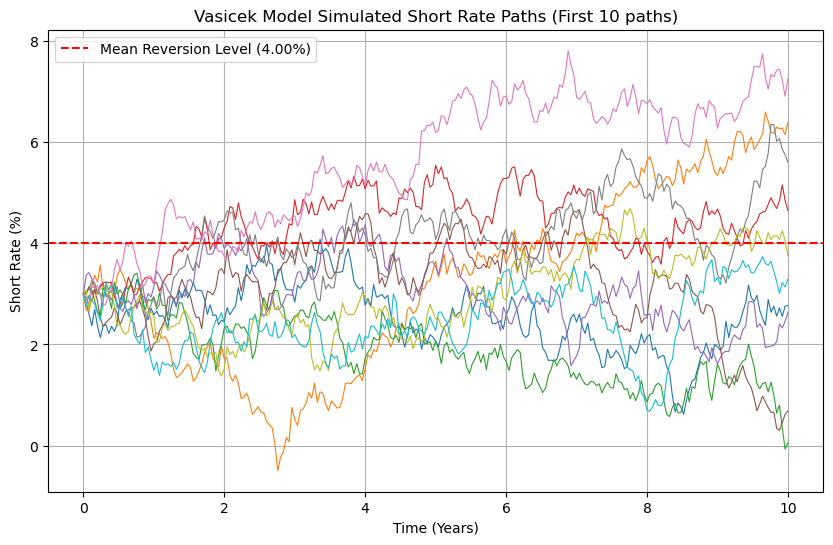


--- CIR Monte Carlo ---
CIR MC ZCB Price (Paths=10000): $692.8913
Difference from Analytical CIR: $0.8030


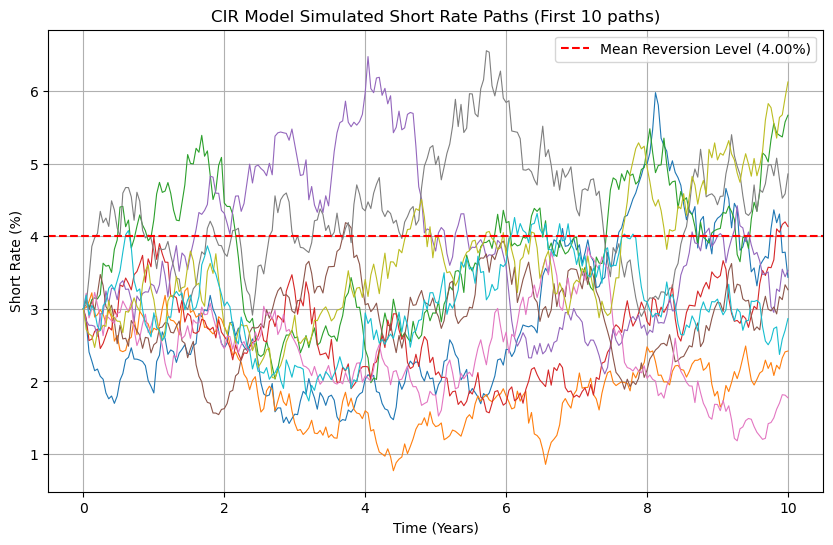

In [176]:
    # --- Phase 6: Monte Carlo Simulation (Interest Rate Paths & Basic Bond Pricing) ---
    print("\n--- Phase 6: Monte Carlo Simulation for Interest Rates and ZCB Pricing ---")
    mc_num_paths = 10000 # Number of simulated paths
    mc_num_steps = 250 # Number of steps per year * T_zcb (e.g., 250 for daily steps over 1 year)

    # Vasicek MC
    print("\n--- Vasicek Monte Carlo ---")
    vasicek_mc_price, vasicek_paths = monte_carlo_zcb_pricing(
        r0_model, (kappa_v, theta_v, sigma_v), T_zcb, mc_num_steps, mc_num_paths, 'vasicek', face_value=1000
    )
    print(f"Vasicek MC ZCB Price (Paths={mc_num_paths}): ${vasicek_mc_price:.4f}")
    print(f"Difference from Analytical Vasicek: ${abs(vasicek_mc_price - (vasicek_price * 1000)):.4f}")

    # Plot a few Vasicek paths
    plt.figure(figsize=(10, 6))
    for i in range(min(10, mc_num_paths)): # Plot up to 10 paths
        plt.plot(np.linspace(0, T_zcb, mc_num_steps + 1), vasicek_paths[i] * 100, linewidth=0.8)
    plt.axhline(theta_v * 100, color='red', linestyle='--', label=f'Mean Reversion Level ({theta_v*100:.2f}%)')
    plt.title(f'Vasicek Model Simulated Short Rate Paths (First {min(10, mc_num_paths)} paths)')
    plt.xlabel('Time (Years)')
    plt.ylabel('Short Rate (%)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # CIR MC
    print("\n--- CIR Monte Carlo ---")
    cir_mc_price, cir_paths = monte_carlo_zcb_pricing(
        r0_model, (kappa_c, theta_c, sigma_c), T_zcb, mc_num_steps, mc_num_paths, 'cir', face_value=1000
    )
    print(f"CIR MC ZCB Price (Paths={mc_num_paths}): ${cir_mc_price:.4f}")
    print(f"Difference from Analytical CIR: ${abs(cir_mc_price - cir_price):.4f}")

    # Plot a few CIR paths
    plt.figure(figsize=(10, 6))
    for i in range(min(10, mc_num_paths)): # Plot up to 10 paths
        plt.plot(np.linspace(0, T_zcb, mc_num_steps + 1), cir_paths[i] * 100, linewidth=0.8)
    plt.axhline(theta_c * 100, color='red', linestyle='--', label=f'Mean Reversion Level ({theta_c*100:.2f}%)')
    plt.title(f'CIR Model Simulated Short Rate Paths (First {min(10, mc_num_paths)} paths)')
    plt.xlabel('Time (Years)')
    plt.ylabel('Short Rate (%)')
    plt.grid(True)
    plt.legend()
    plt.show()

